In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import cmasher as cm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import jax
from scipy import stats
import matplotlib.gridspec as grid
from matplotlib.colors import LogNorm

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

There are 7562 GC stars
There are 7737 GC stars


In [4]:
apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

In [5]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [6]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')

There are 174274 stars in the parent sample


In [7]:
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError

A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [8]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-8.4,31.8,8.4]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz


In [9]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data)

In [10]:
# Eilers rotation curve
R = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(R-8.275)
Rg = (-data['L'][:,2]/vcirc)
phi = np.arctan(data['xyz'][:,1]/-data['xyz'][:,0])
phi_x1 = R*np.cos(phi)
phi_y1 = R*np.sin(phi)
vr = vRvTvz[:,0]*220.
print(R)
deltaR = R-Rg


[ 9.87188323  8.63580707 22.58525074 ...  5.15168728  5.15372958
  5.80486113]


In [29]:
rg_bins = np.around(np.linspace(0,14,15),decimals=2)
print(rg_bins)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [36]:
def plot_Rg_zmax_var_dens(Rg,zmax,var1,var2, Rg_n = 14, zmax_n = 3,label1 = '[Mg/H]',label2='[Fe/Mg]',\
                         xlim0=-1,xlim1=0.6,ylim0=-0.5,ylim1=0.15,nstarsx=0.0,nstarsy=-0.475):
    
    """
    Function to plot two variables (var1,var2) gridded in an Rg-zmax plane
    
    INPUT: Guiding-centre radius, maximum vertical height, variable 1, variable 2
    
    OUTPUT: Plot of var 1 vs var 2 in a grid of Rg and zmax
    
    """
    
    # split the Rg array into Rg_n bins (input 5)
    rg_bins = np.around(np.linspace(0,14,Rg_n+1),decimals=2)
    zmax_bins = np.flip(np.around(np.linspace(0,3,zmax_n+1),decimals=2))
    
    # create the plot
    fig, all_axes = plt.subplots(zmax_n,Rg_n, constrained_layout=True, figsize=(60, 12), sharex=True, sharey=True,rasterized=True)
    
    fig.suptitle('Guiding-centre radius, $R_{g}$ [kpc]', fontsize=50, y = 1.1)
    fig.supylabel('Maximum vertical height, $z_{\mathrm{max}}$ [kpc]',fontsize=50, x= -0.04)    

    # loop over the grid
    for indx, i in enumerate(zmax_bins[:-1]):
        axis = all_axes[indx]
        for jndx, j in enumerate(rg_bins[:-1]):
            ax = axis[jndx]
            # create a mask for every loop
            mask_loop = (Rg>j)&(Rg<rg_bins[jndx+1])&(zmax<i)&(zmax>zmax_bins[indx+1])
            # make the plot
            ax.hist2d(var1[mask_loop],var2[mask_loop],bins=100,norm=LogNorm(),cmap=cm.cosmic)

            ax.set_xlim(xlim0,xlim1)
            ax.set_ylim(ylim0,ylim1)
#             ax.plot([-0.6,-0.1],[0.35,0.2],color='r',lw=5)
            ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
            ax.text(nstarsx,nstarsy,r'N$_{\mathrm{stars}}$ '+str(len(var2[mask_loop])),fontsize=20)

    
    all_axes[0,0].set_title(r'Inner Galaxy'+'\n' +str('%5.2f' %rg_bins[0])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[1]),fontsize=28,pad=15)
    all_axes[0,1].set_title(r'' +str('%5.2f' %rg_bins[1])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[2]),fontsize=28,pad=15)
    all_axes[0,2].set_title(r'' +str('%5.2f' %rg_bins[2])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[3]),fontsize=28,pad=15)
    all_axes[0,3].set_title(r'' +str('%5.2f' %rg_bins[3])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[4]),fontsize=28,pad=15)
    all_axes[0,4].set_title(r'' +str('%5.2f' %rg_bins[4])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[5]),fontsize=28,pad=15)
    all_axes[0,5].set_title(r'' +str('%5.2f' %rg_bins[5])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[6]),fontsize=28,pad=15)
    all_axes[0,6].set_title(r'' +str('%5.2f' %rg_bins[6])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[7]),fontsize=28,pad=15)
    all_axes[0,7].set_title(r'' +str('%5.2f' %rg_bins[7])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[8]),fontsize=28,pad=15)
    all_axes[0,8].set_title(r'' +str('%5.2f' %rg_bins[8])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[9]),fontsize=28,pad=15)
    all_axes[0,9].set_title(r'' +str('%5.2f' %rg_bins[9])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[10]),fontsize=28,pad=15)
    all_axes[0,10].set_title(r'' +str('%5.2f' %rg_bins[10])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[11]),fontsize=28,pad=15)
    all_axes[0,11].set_title(r'' +str('%5.2f' %rg_bins[11])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[12]),fontsize=28,pad=15)
    all_axes[0,12].set_title(r'' +str('%5.2f' %rg_bins[12])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[13]),fontsize=28,pad=15)
    all_axes[0,13].set_title(r'Outer Galaxy'+'\n' +str('%5.2f' %rg_bins[13])+ r'$<$ $R_{g}$ [kpc] $<$ '+str('%5.2f' %rg_bins[14]),fontsize=28,pad=15)

    all_axes[0,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[1])+ r'$<$ $z_{\mathrm{max}}$ [kpc] $<$ '+str('%5.0f' %zmax_bins[0])+' \n '+str(label2),fontsize=28,labelpad=15)
    all_axes[1,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[2])+ r'$<$ $z_{\mathrm{max}}$ [kpc] $<$ '+str('%5.0f' %zmax_bins[1])+' \n '+str(label2),fontsize=28,labelpad=15)
    all_axes[2,0].set_ylabel(r'' +str('%5.0f' %zmax_bins[3])+ r'$<$ $z_{\mathrm{max}}$ [kpc] $<$ '+str('%5.0f' %zmax_bins[2])+' \n '+str(label2),fontsize=28,labelpad=15)
    
#     all_axes[0,0].text(-0.35,1.,'Inner Galaxy', fontsize=40)
#     all_axes[0,-1].text(-0.35,1.,'Outer Galaxy', fontsize=40)

#     fig.arrow(0.5,0.35,dx=5,dy=1,color='k',head_width=0.2,head_length=0.2)
#     cbar = fig.colorbar(color, ax = axis, aspect=15)
#     cbar.set_label(label='N$_{\mathrm{stars}}$',fontsize=25)
#     cbar.ax.tick_params(labelsize=25)
    
    for ax in all_axes[-1]:
        ax.set_xlabel(label1,fontsize=28,labelpad=4)
        
    plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/femg-rg-zmax-allrads.pdf',dpi=200, bbox_inches = 'tight')

#     for ax in all_axes[:, 0]:
#         ax.set_ylabel(label2,fontsize=30)


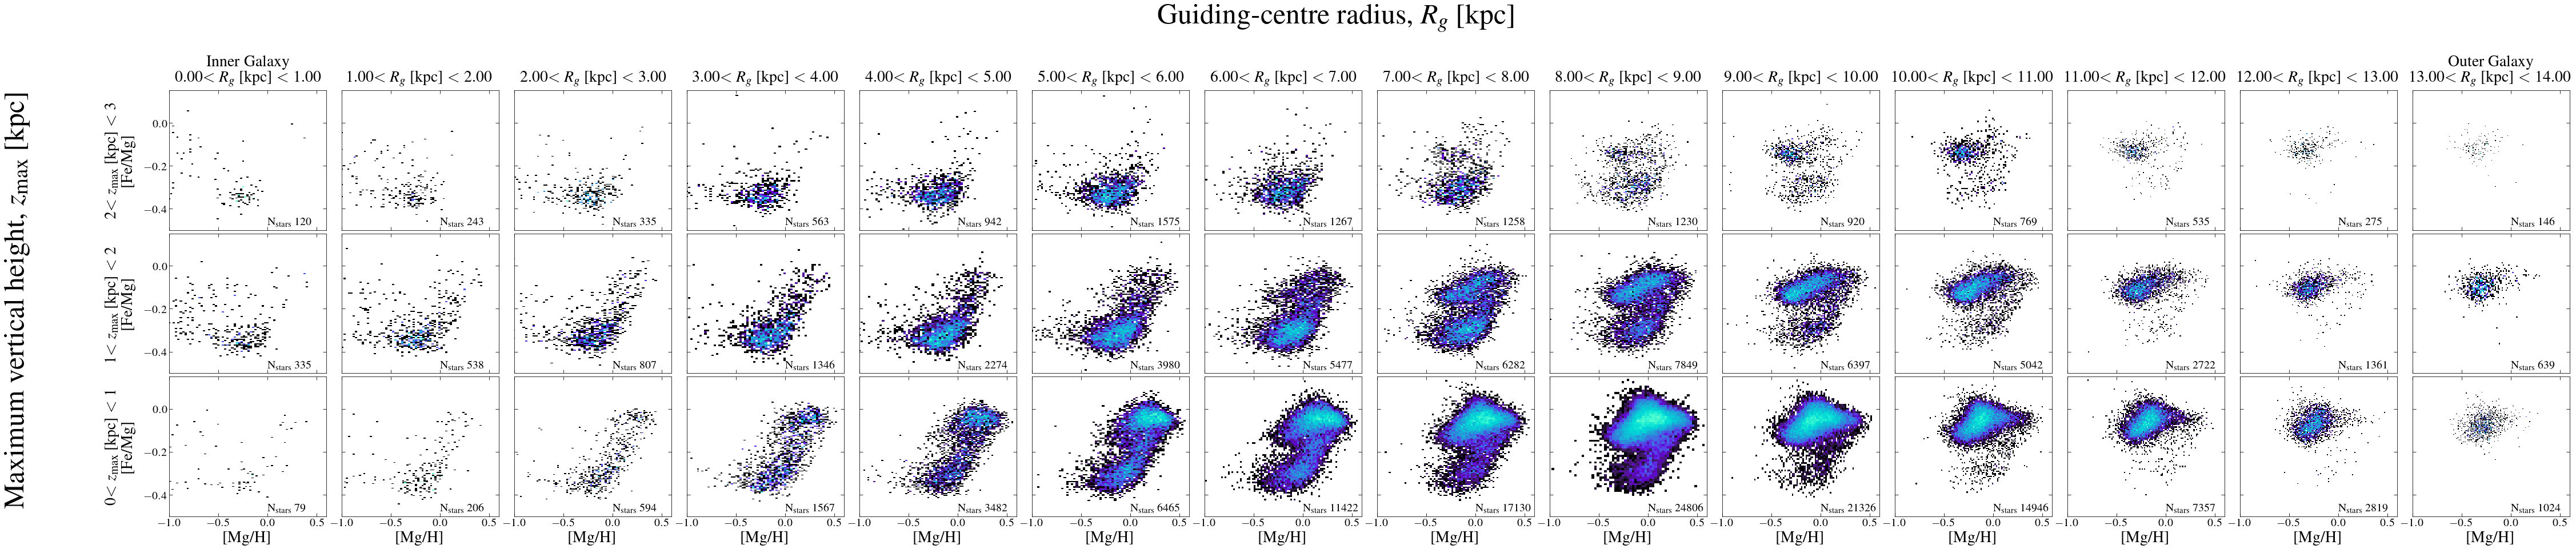

In [37]:
mgh = data['MG_FE']+data['FE_H']
femg = data['FE_H']-mgh

mask_plot = (Rg>0)&(Rg<14)&(data['z_max']>0)&(data['z_max']<3)&(np.abs(femg)<3)&(np.abs(mgh)<3)&mask


plot_Rg_zmax_var_dens(Rg[mask_plot],data['z_max'][mask_plot],mgh[mask_plot],femg[mask_plot])

# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/femg-rg-zmax-allrads.pdf',dpi=200, bbox_inches = 'tight')



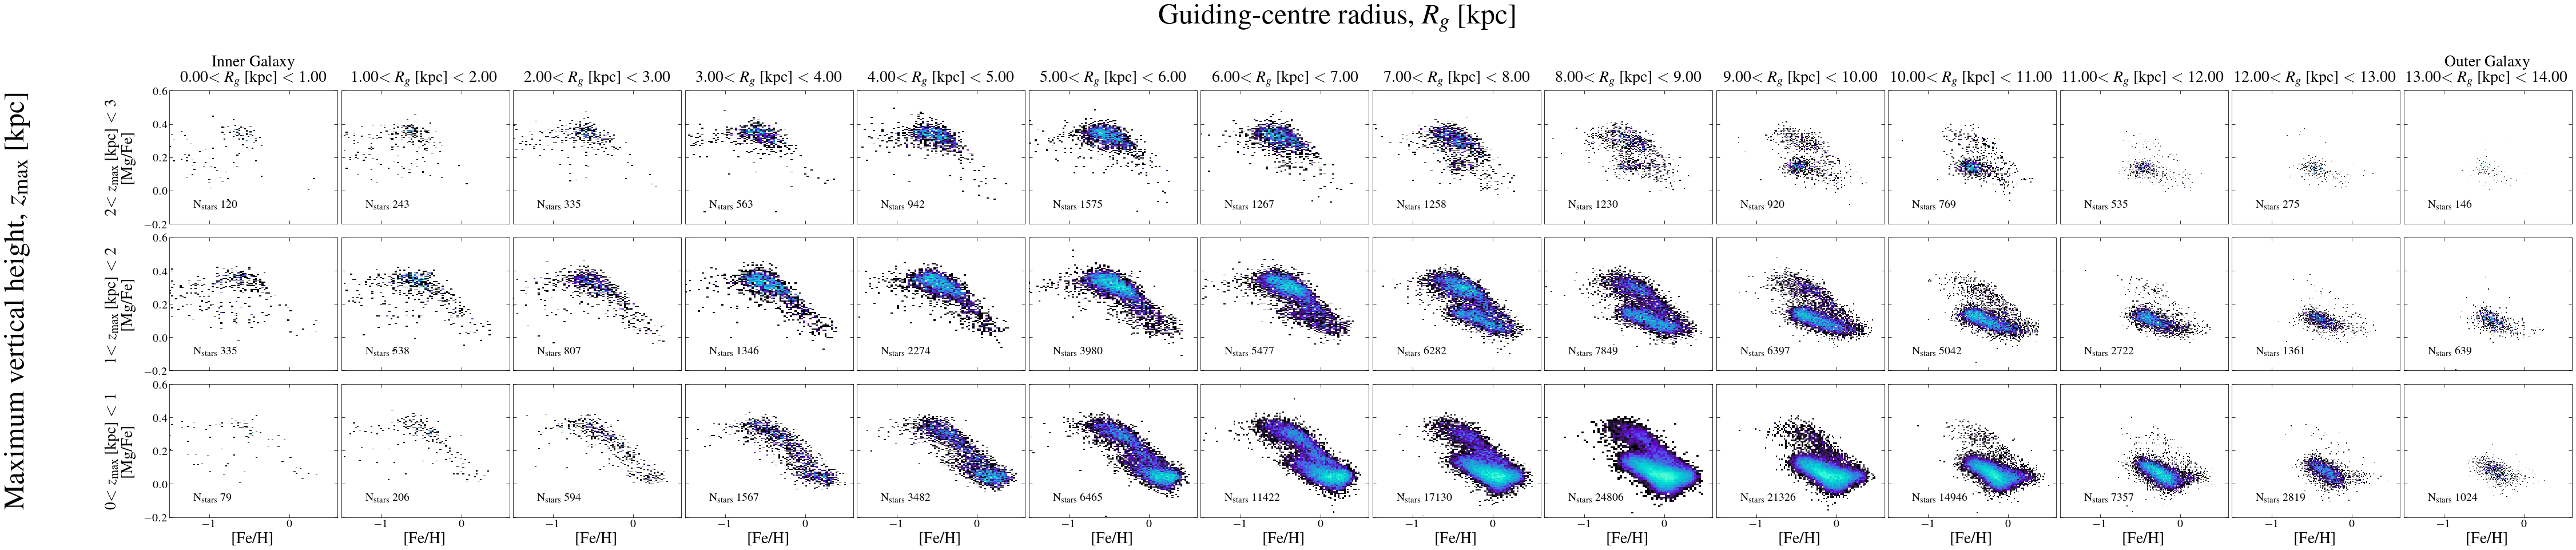

In [35]:
mgh = data['MG_FE']+data['FE_H']
femg = data['FE_H']-mgh

mask_plot = (Rg>0)&(Rg<14)&(data['z_max']>0)&(data['z_max']<3)&(np.abs(data['FE_H'])<3)&(np.abs(data['MG_FE'])<3)&mask


plot_Rg_zmax_var_dens(Rg[mask_plot],data['z_max'][mask_plot],data['FE_H'][mask_plot],data['MG_FE'][mask_plot],\
                     label1='[Fe/H]',label2='[Mg/Fe]',xlim0=-1.5,xlim1=0.6,ylim0=-0.2,ylim1=0.6,\
                     nstarsx=-1.2,nstarsy=-0.1)

# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-cartography/plots/tinsley-rg-zmax-allrads.pdf',dpi=200, bbox_inches = 'tight')
